## Authors: Pablo Mollá, Pavlo Poliuha and Junjie Chen

# Neural network: first experiments with a linear model

In this lab exercise we will code a neural network using numpy, without a neural network library.
Next week, the lab exercise will be to extend this program with hidden layers and activation functions.

The task is digit recognition: the neural network has to predict which digit in $\{0...9\}$ is written in the input picture. We will use the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, a standard benchmark in machine learning.

The model is a simple linear  classifier $o = \operatorname{softmax}(Wx + b)$ where:
* $x$ is an input image that is represented as a column vector, each value being the "color" of a pixel
* $W$ and $b$ are the parameters of the classifier
* $\operatorname{softmax}$ transforms the output weight (logits) into probabilities
* $o$ is column vector that contains the probability of each category

We will train this model via stochastic gradient descent by minimizing the negative log-likelihood of the data:
$$
    \hat{W}, \hat{b} = \operatorname{argmin}_{W, b} \sum_{x, y} - \log p(y | x)
$$
Although this is a linear model, it classifies raw data without any manual feature extraction step.

In [1]:
# import libs that we will use
import os
import numpy as np
import matplotlib.pyplot as plt
import math

# To load the data we will use the script of Gaetan Marceau Caron
# You can download it from the course webiste and move it to the same directory that contains this ipynb file
import dataset_loader

%matplotlib inline

In [2]:
# Download mnist dataset 
if("mnist.pkl.gz" not in os.listdir(".")):
    # this link doesn't work any more,
    # seach on google for the file "mnist.pkl.gz"
    # and download it
    !wget https://github.com/mnielsen/neural-networks-and-deep-learning/raw/master/data/mnist.pkl.gz

# if you have it somewhere else, you can comment the lines above
# and overwrite the path below
mnist_path = "./mnist.pkl.gz"


In [3]:
# Load the 3 splits
train_data, dev_data, test_data = dataset_loader.load_mnist(mnist_path)

Each dataset is a list with two elemets:
* data[0] contains images
* data[1] contains labels

Data is stored as numpy.ndarray. You can use data[0][i] to retrieve image number i and data[1][i] to retrieve its label.

Label: 3


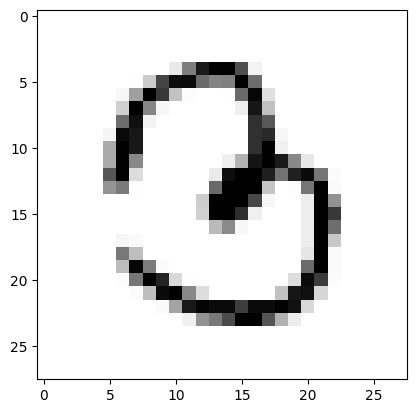

In [4]:
index = 900
label = train_data[1][index]
picture = train_data[0][index]

print("Label: %i" % label)
plt.imshow(picture.reshape(28,28), cmap='Greys')

**Question 1:** What are the characteristics of training data? (number of samples, dimension of input, number of labels)

The documentation of ndarray class is available here: https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.html

In [5]:
train_data[0].shape

(50000, 784)

In [6]:
def getDimDataset(data):
    X, Y = data
    
    # Number of samples
    n_training = X.shape[0]  
    
    # Dimension of input/features per sample
    n_feature = X.shape[1]
    
    # Number of unique labels/classes
    n_label = len(np.unique(Y))
    
    return n_training, n_feature, n_label

In [7]:
n_training, n_feature, n_label = getDimDataset(train_data)

print(f"Number of training samples: {n_training}")
print(f"Dimension of input/features: {n_feature}")
print(f"Number of labels/classes: {n_label}")



Number of training samples: 50000
Dimension of input/features: 784
Number of labels/classes: 10


- The number 50,000 (50k) represents the total number of training samples in the dataset. In the context of the MNIST dataset, each of these samples is an image of a handwritten digit.

- The number 784 represents the dimension of the input features for each sample in the dataset. Specifically, for the MNIST dataset, which consists of grayscale images of handwritten digits (0 through 9), each image is 28 pixels by 28 pixels. When these images are unrolled into a single vector (which is a common preprocessing step for feeding images into a machine learning model), they become a vector with 28×28=784 elements.

- The number 10 represents the total number of unique labels or classes in the dataset. Since MNIST is a dataset of handwritten digits from 0 to 9, there are 10 possible classes that each image can be classified into, corresponding to each digit. This means the dataset is a multi-class classification problem with 10 distinct classes.

# 1. Building functions

We now need to build functions that are required for the neural network.
$$
    o = \operatorname{softmax}(Wx + b) \\
    L(x, y) = -\log p(y | x) = -\log o[y]
$$

Note that in numpy, operator @ is used for matrix multiplication while * is used for element-wise multiplication.
The documentation for linear algebra in numpy is available here: https://docs.scipy.org/doc/numpy/reference/routines.linalg.html

The first operation is the affine transformation $v = Wx + b$.
To compute the gradient, it is often convenient to write the forward pass as $v[i] = b[i] + \sum_j W[i, j] x[j]$.

Let's explain the following code:

1. `W` is a 2D NumPy array with a shape of (5, 10). It will represent the weights of the neural network layer where we have 10 neurons (output dimension) and each neuron is connected to an input of dimension 5.

2. `x` is a 2D NumPy array with a shape of (1, 5). This represents a single input sample with 5 features.

3. `np.matmul(W.transpose(1,0), x.transpose(1,0))` performs matrix multiplication between the transposed `W` and the transposed `x`. The resulting matrix multiplication is valid because the inner dimensions (5 from `W`'s transpose and 5 from `x`'s transpose) match. The operation will result in a new matrix with a shape of (10, 1), which is the result of applying the transposed weight matrix to the input vector.

This matrix multiplication can be thought of as taking the input `x` and transforming it into a new space as defined by the transposed weight matrix `W`. If `W` were the weights of a neural network layer, then this operation would be computing the activation of the previous layer (because of the transpose) given the current layer's input `x`. However, this kind of operation (using the transpose of the weights matrix) isn't typical in a forward pass of a neural network—it's more akin to what happens during the backpropagation step when gradients are being computed.

In [8]:
W = np.random.randn(5,10)
x = np.random.randn(1,5)
print(W.transpose(1,0).shape)
np.matmul(W.transpose(1,0), x.transpose(1,0))

(10, 5)


array([[-0.74614385],
       [-1.64078612],
       [ 0.45543486],
       [ 0.54637237],
       [ 0.67491943],
       [-1.01043933],
       [ 0.23227993],
       [ 0.51032964],
       [ 1.03048434],
       [-1.460326  ]])

**Question 2:**  Complete the two functions `affine_transform` and `backward_affine_transform`. The last function computes the gradient of the loss function according to weights of the linear module. The gradient of the loss according to output of the linear module is given as last parameter of the function backward_affine_transform.


### Analytical Explanation

To provide a detailed analytical explanation of the backward pass through an affine transformation using the given operations, let's consider the following:

1. **Forward Pass:**
   - Affine Transformation: $y = Wx + b$
   
   - Where $x$ is our input vector (size $d \times 1$), $W$ is the weight matrix (size $m \times d$), $b$ is the bias vector (size $m \times 1$), and $y$ is the output vector (size $m \times 1$).

2. **Backward Pass:**
   - Let's consider the loss function $L$. We are interested in how changes in $W$ and $b$ affect $L$, i.e., we want to find $\frac{\partial L}{\partial W}$ and $\frac{\partial L}{\partial b}$.
   
   - Given the incoming gradient of the loss with respect to the output of the affine layer, $\frac{\partial L}{\partial y}$ (denoted by $g$ and of size $m \times 1$).


### Gradient with respect to W ($\frac{\partial L}{\partial W}$)

Given that $L$ is a function of $y$ (i.e., $L(y)$), and $y$ is a function of $W$, applying the chain rule yields:

$$ \frac{\partial L}{\partial W} = \frac{\partial L}{\partial y} \cdot \frac{\partial y}{\partial W} $$

Where:
- $\frac{\partial L}{\partial y}$ is $g$, our incoming gradient.

- $\frac{\partial y}{\partial W}$ can be thought of as how each component of $y$ changes with a small change in $W$.

Since $y = Wx + b$, a small change in $W$ leads to a change in $y$ exactly proportional to $x$.

$$ \frac{\partial y}{\partial W} = x^T $$

This gives us:

$$ \frac{\partial L}{\partial W} = \underbrace{\frac{\partial L}{\partial y}}_{g} \cdot \underbrace{\frac{\partial y}{\partial W}}_{x^T} = g \cdot x^T $$


This is why we calculate $g_W = np.dot(g, x.T)$ in the code to get the gradient of $L\$ with respect to $W$.

### Gradient with respect to b ($\frac{\partial L}{\partial b}$)

- Similarly, since $b$ directly adds to $y$, the change in $L$ with respect to a change in $b$ is simply the gradient $g$ itself, aggregated across all samples. 

- Since $y = Wx + b$, we obtain:

$$ \frac{\partial y}{\partial b} = 1 \text{ (vector of 1s)} $$

This gives us:

$$ \frac{\partial L}{\partial W} = \underbrace{\frac{\partial L}{\partial y}}_{g} \cdot \underbrace{\frac{\partial y}{\partial W}}_{1} = g \cdot 1 = \sum g $$


Thus, $g_b = np.sum(g, axis=0, keepdims=True)$ calculates the sum of gradients across the batch (if in a batch setting) or simply keeps $g$ in the correct shape for updates.


In [9]:
# Forward Propagation Transformation
def affine_transform(W, b, x):
    # Input:
    # - W: projection matrix
    # - b: bias
    # - x: input features
    # Output:
    # - vector
    return W @ x.T + b


# Backward Propagation Tranformation
def backward_affine_transform(W, b, x, g):
    # Input:
    # - W: projection matrix
    # - b: bias
    # - x: input features
    # - g: incoming gradient
    # Output:
    # - g_W: gradient wrt W
    # - g_b: gradient wrt b
    g_W = np.outer(g, x.T)
    g_b = g*(np.ones(b.shape))    
    return g_W, g_b

In [10]:
W = np.asarray([[ 0.63024213,  0.53679375, -0.92079597],
 [-0.1155045,   0.62780356, -0.67961305],
 [ 0.08465286, -0.06561815, -0.39778322],
 [ 0.8242268,   0.58907262, -0.52208052],
 [-0.43894227, -0.56993247,  0.09520727]])


b = np.asarray([ 0.42706842,  0.69636598, -0.85611933, -0.08682553,  0.83160079])
x = np.asarray([-0.32809223, -0.54751413,  0.81949319])

o_gold = np.asarray([-0.82819732, -0.16640748, -1.17394705, -1.10761496,  1.36568213])
g = np.asarray([-0.08938868,  0.44083873, -0.2260743,  -0.96196726, -0.53428805])
g_W_gold = np.asarray([[ 0.02932773,  0.04894156, -0.07325341],
 [-0.14463576, -0.24136543,  0.36126434],
 [ 0.07417322,  0.12377887, -0.18526635],
 [ 0.31561399,  0.52669067, -0.78832562],
 [ 0.17529576,  0.29253025, -0.43784542]])
g_b_gold = np.asarray([-0.08938868,  0.44083873, -0.2260743,  -0.96196726, -0.53428805])


# quick test of the forward pass
o = affine_transform(W, b, x)
if o.shape != o_gold.shape:
    raise RuntimeError("Unexpected output dimension: got %s, expected %s" % (str(o.shape), str(o_gold.shape)))
if not np.allclose(o, o_gold):
    raise RuntimeError("Output of the affine_transform function is incorrect")
    
# quick test if the backward pass
g_W, g_b = backward_affine_transform(W, b, x, g)
if g_W.shape != g_W_gold.shape:
        raise RuntimeError("Unexpected gradient dimension for W: got %s, expected %s" % (str(g_W.shape), str(g_W_gold.shape)))
if g_b.shape != g_b_gold.shape:
        raise RuntimeError("Unexpected gradient dimension for b: got %s, expected %s" % (str(g_b.shape), str(g_b_gold.shape)))
if not np.allclose(g_W, g_W_gold):
    raise RuntimeError("Gradient of W is incorrect")
if not np.allclose(g_b, g_b_gold):
    raise RuntimeError("Gradient of b is incorrect")

The softmax function:
$$
     o = \operatorname{softmax}(w)
$$
where $w$ is a vector of logits in $\mathbb R$ and $o$ a vector of probabilities such that:
$$
    o[i] = \frac{\exp(w[i])}{\sum_j \exp(w[j])}
$$
We do not need to implement the backward for this experiment.

**Question 3** Implement the function softmax

In [11]:
def softmax(x):
    # Input:
    # - x: vector of logits
    # Output
    # - vector of probabilities
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

**WARNING:** is your implementation numerically stable?

The $\exp$ function results in computations that overflows (i.e. results in numbers that cannot be represented with floating point numbers).
Therefore, it is always convenient to use the following trick to improve stability: https://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/

In [12]:
# Example for testing the numerical stability of softmax
# It should return [1., 0. ,0.], not [nan, 0., 0.]
z = [1000000,1,100]
print(softmax(z))

[1. 0. 0.]


**Question 4**: From the result of the cell above, what can you say about the softmax output, even when it is stable?

In the previous example, we have used the softmax function on the input z = [1000000,1,100]. 

- Without the numerical stability trick, exponentiating such large numbers would result in overflow, potentially leading to NaN (not a number) values. However, with the implemented trick, the softmax function can still output a valid probability distribution [1., 0., 0.]. 

- This result tells us that even for inputs with large values, the output probabilities are calculated correctly without numerical overflow or underflow.

So, even when the softmax function is numerically stable:

- The outputs are valid probabilities that sum up to 1.
- The output does not suffer from overflow or underflow issues.
- The function can handle a wide range of input values, including very large or small logits, without returning erroneous results.

In [13]:
# Just too simple test for the softmax function
x = np.asarray([0.92424884, -0.92381088, -0.74666024, -0.87705478, -0.54797015])
y_gold = np.asarray([0.57467369, 0.09053556, 0.10808233, 0.09486917, 0.13183925])

y = softmax(x)
if not np.allclose(y, y_gold):
    raise RuntimeError("Output of the softmax function is incorrect")

Finally, we build the loss function and its gradient for training the network.

The loss function is the negative log-likelihood defined as:
$$
    \mathcal L(x, gold) = -\log \frac{\exp(x[gold])}{\sum_j \exp(x[j])} = -x[gold] + \log \sum_j \exp(x[j])
$$
This function is also called the cross-entropy loss (in Pytorch, different names are used dependending if the inputs are probabilities or raw logits).

Similarly to the softmax, we have to rely on the log-sum-exp trick to stabilize the computation: https://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/

**Question 5:** Implement the forward and backward function for the negative loglikelihood

### Example of Process

#### Forward Pass:


Input:

- Logits from the neural network: x = [2.0, 1.0, 0.5]
- True class (gold): gold = 0 (assuming classes are numbered 0, 1, and 2)

##### 1. First, we compute the softmax probabilities to convert the logits into probabilities:

- Calculate exp(x[j]) for each class j.
- Sum these exponentials to get sum_j exp(x[j]).

The probability for the true class gold is exp(x[gold]) / sum_j exp(x[j]).

##### 2. Next, we compute the Negative Log-Likelihood:

- Take the negative log of the probability of the true class: -log(exp(x[gold]) / sum_j exp(x[j])).
- Simplify using the properties of logarithms to get -x[gold] + log(sum_j exp(x[j])).

##### Example Computation:

1. Softmax Probabilities
- softmax_probabilities = exp([2.0, 1.0, 0.5]) / sum(exp([2.0, 1.0, 0.5]))
- softmax_probabilities ≈ [0.6, 0.3, 0.1] (these are not exact values, just approximations for illustration)

2. Negative Log-Likelihood
- NLL = -log(0.6) ≈ -(-0.51) ≈ 0.51 (using a common logarithm approximation)

#### Backward Pass:


- Now, we compute the gradient of the loss function with respect to the input logits. This gradient indicates how much a small change in each logit would change the loss.

1. Subtract 1 from the probability of the true class (since we want to decrease the loss for the correct class, making its probability closer to 1).
2. Leave the probabilities of the incorrect classes as they are (since increasing their probabilities would increase the loss).

##### Example Computation:

- grad = softmax_probabilities (copy probabilities)
- grad[gold] = grad[gold] - 1 (adjust for true class)
- grad ≈ [0.6 - 1, 0.3, 0.1]
- grad ≈ [-0.4, 0.3, 0.1]

In [14]:
# Input:
# - x: vector of logits
# - gold: index of the gold class
# Output:
# - scalare equal to -log(softmax(x)[gold])
def nll(x, gold):
    return -np.log(softmax(x)[gold])

# Input:
# - x: vector of logits
# - gold: index of the gold class
# - gradient (scalar)
# Output:
# - gradient wrt x
def backward_nll(x, gold, g):
    g_x = softmax(x)
    g_x[gold] -= 1
    g_x *= g
    return g_x

In [15]:
# test
x = np.asarray([-0.13590009, -0.83649656,  0.03130881,  0.42559402,  0.08488182])
y_gold = 1.5695014420179738
g_gold = np.asarray([ 0.17609875,  0.08739591, -0.79185107,  0.30875221,  0.2196042 ])

y = nll(x, 2)
g = backward_nll(x, 2, 1.)

if not np.allclose(y, y_gold):
    raise RuntimeError("Output is incorrect")

if g.shape != g_gold.shape:
        raise RuntimeError("Unexpected gradient dimension: got %s, expected %s" % (str(g.shape), str(g_gold.shape)))
if not np.allclose(g, g_gold):
    raise RuntimeError("Gradient is incorrect")

The following code tests the implementation of the gradient using finite-difference approximation, see:
- https://timvieira.github.io/blog/post/2017/04/21/how-to-test-gradient-implementations/

Your implementation should pass this test.

In [16]:
# this is python re-implementation of the test from the Dynet library
# https://github.com/clab/dynet/blob/master/dynet/grad-check.cc

def is_almost_equal(grad, computed_grad):
    #print(grad, computed_grad)
    f = abs(grad - computed_grad)
    m = max(abs(grad), abs(computed_grad))

    if f > 0.01 and m > 0.:
        f /= m

    if f > 0.01 or math.isnan(f):
        return False
    else:
        return True

def check_gradient(function, weights, true_grad, alpha = 1e-3):
    # because input can be of any dimension,
    # we build a view of the underlying data with the .shape(-1) method
    # then we can access any element of the tensor as a elements of a list
    # with a single dimension
    weights_view = weights.reshape(-1)
    true_grad_view = true_grad.reshape(-1)
    for i in range(weights_view.shape[0]):
        old = weights_view[i]

        weights_view[i] = old - alpha
        value_left = function(weights).reshape(-1)

        weights_view[i] = old + alpha
        value_right = function(weights).reshape(-1)

        weights_view[i] = old
        grad = (value_right - value_left) / (2. * alpha)

        if not is_almost_equal(grad, true_grad_view[i]):
            return False

        return True

# 2. Parameter initialization

We are now going to build the function that will be used to initialize the parameters of the neural network before training.
Note that for parameter initialization you must use **in-place** operations:

In [17]:
# create a random ndarray
a = np.random.uniform(-1, 1, (5,))

# this does not change the data of the ndarray created above!
# it creates a new ndarray and replace the reference stored in a
a = np.zeros((5, ))

# this will change the underlying data of the ndarray that a points to
a[:] = 0

# similarly, this creates a new array and change the object pointed by a
a = a + 1

# while this change the underlying data of a
a += 1

For an affine transformation, it is common to:
* initialize the bias to 0
* initialize the projection matrix with Glorot initialization (also known as Xavier initialization)

The formula for Glorot initialization can be found in equation 16 (page 5) of the original paper: http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf

**Question 6:** Fill the two initilization functions below

#### Weights Matrix

- `Xavier initialization`, also known as Glorot initialization, is a method of initializing the weights of a neural network to help with the convergence during training. It is named after Xavier Glorot, who, along with `Yoshua Bengio`, introduced the method in a paper in 2010 to address the problems of training deep neural networks.

- The `key` idea behind Xavier initialization is to initialize the weights in such a way that the variance of the outputs of each layer is the same as the variance of its inputs. This helps prevent the gradients from becoming too small or too large, a problem that can lead to either vanishing gradients or exploding gradients, respectively.

- The Xavier initialization sets a layer's weights $W$ using a random distribution that has a zero mean and a specific variance that depends on the number of input and output units of the layer:

$$ \text{Var}(W) = \frac{2}{n_{\text{in}} + n_{\text{out}}}$$

Where:
- $n_{\text{in}}$ is the number of units (neurons) in the layer's input (i.e., the size of the previous layer).
- $n_{\text{out}}$ is the number of units in the layer's output (i.e., the size of the current layer).

1. For the `uniform distribution`, the weights are initialized using the following range:

$$ W \sim \text{Uniform}\left(-\sqrt{\frac{6}{n_{\text{in}} + n_{\text{out}}}}, \sqrt{\frac{6}{n_{\text{in}} + n_{\text{out}}}}\right) $$

- We will use this one for our Neural Network.

2. For the `normal distribution`, they are initialized using:

$$ W \sim \mathcal{N}\left(0, \sqrt{\frac{2}{n_{\text{in}} + n_{\text{out}}}}\right) $$

In practice, when using libraries like TensorFlow or PyTorch, Xavier initialization can often be specified by using the appropriate initializer when constructing layers of a neural network. For example with TensorFlow, we could have used `tf.keras.initializers.GlorotUniform()` for uniform Xavier initialization or `tf.keras.initializers.GlorotNormal()` for normal Xavier initialization.

#### Bias

The Bias vector is set to 0 due to 2 main reasons:

- Kickstarting Learning: We can think of the bias as a starting point for the neurons. Setting the bias to zero is like starting from a neutral position, allowing the weights (which are initialized using the Glorot method) to take the lead in learning from the data. This way, each neuron begins learning without any initial push in a particular direction, making it easier for the network to adjust and learn the patterns in the data effectively.

- Keeping Things Balanced: By starting the biases at zero, we help keep the outputs of neurons initially centered around zero. This balance is crucial because it helps avoid extreme values in the neurons' outputs at the beginning of training, making it smoother for the network to learn and adjust as training progresses.

In [18]:
def zero_init(b):
    return np.zeros(b).reshape(-1,1)

def glorot_init(W):
    return np.random.uniform(-np.sqrt(6.0/(W[0]+W[1])), np.sqrt(6.0/(W[0]+W[1])),W)

# 3. Building and training the neural network

In our simple example, creating the neural network is simply instantiating the parameters $W$ and $b$.
They must be ndarray object with the correct dimensions.

**Question 7:** Fill the function that create and initialize the parameters

In [19]:
def create_parameters(dim_input, dim_output):
    W = glorot_init((dim_output, dim_input))
    b =  zero_init(dim_output)
    return W, b

The recent success of deep learning is (partly) due to the ability to train very big neural networks.
However, researchers became interested in building small neural networks to improve computational efficiency and memory usage.
Therefore, we often want to compare neural networks by their number of parameters, i.e. the size of the memory required to store the parameters.

**Question 8:** Fill the function that  print the number of parameters of the linear model

In [20]:
def print_n_parameters(W, b):
    # If W is (5,3) then W.size = 15
    n = W.size + b.size
    print("Number of parameters: %i" % (n))

We can now create the neural network and print its number of parameters:

In [21]:
dim_input = 5
dim_output = 10
W, b = create_parameters(dim_input, dim_output)
print_n_parameters(W, b)

Number of parameters: 60


Finally, the training loop!

The training loop should be structured as follows:
* We do **epochs** over the data, i.e. one epoch is one loop over the dataset
* At each epoch, we first loop over the data and update the network parameters with respect to the loss gradient
* At the end of each epoch, we evaluate the network on the dev dataset
* After all epochs are done, we evaluate our network on the test dataset and compare its performance with the performance on dev (development = validation) dataset

During training, it is useful to print the following information:
* The $\textcolor{red}{\text{mean loss}}$ over the epoch: it should be $\textcolor{red}{\text{decreasing}}$!
* The $\textcolor{green}{\text{accuracy on the dev/val set}}$: it should be $\textcolor{green}{\text{increasing}}$!
* The $\textcolor{green}{\text{accuracy on the train set}}$: it shoud be $\textcolor{green}{\text{increasing}}$!

If you observe a $\textcolor{orange}{\text{decreasing loss}}$ (+ $\textcolor{orange}{\text{increasing accuracy on test data}}$) but $\textcolor{orange}{\text{decreasing accuracy on dev data}}$, your network is $\textcolor{orange}{\text{overfitting}}$!

Once you have built **and tested** this simple training loop, you should introduce the following improvements:
* instead of evaluating on dev after each loop on the training data, you can also evaluate on dev n times per epoch
* shuffle the data before each epoch
* instead of memorizing the parameters of the last epoch only, you should have a copy of the parameters that produced the best value on dev data during training and evaluate on test with those instead of the parameters after the last epoch
* learning rate decay: if you do not observe improvement on dev, you can try to reduce the step size

After you conducted (successful?) experiments, you should write a report with results (in the notebook).

#### Metric: Accuracy 

In [22]:
def accuracy(W, b, X, y):
    logits = affine_transform(W, b, X)
    proprobabilities = softmax(logits)
    predictions = np.argmax(proprobabilities, axis=0)
    return np.mean(predictions == y)

#### Parameter Initilization

In [28]:
# Before training, we initialize the parameters of the network
n_training, dim_input, dim_output = getDimDataset(train_data)

# Initialization of Weights, Bias, n_epochs, learning_rate and two indicators (best_dev_acc and best_params)

# Weights and Bias
W1, b1 = create_parameters(dim_input, dim_output)

# Number of epochs
n_epochs = 20

# Setting initial learning rate
learning_rate = 0.1

# Defining decay factor
#decay_factor = 0.01

# Record the best development accuracy
best_dev_acc = -np.inf

# Record the best model parameters
best_params = (None, None)

In [27]:
from sklearn.utils import shuffle
    
for epoch in range(n_epochs):
    # Shuffle the training data to prevent cycles
    X_train, y_train = shuffle(train_data[0], train_data[1])
    
    epoch_loss = 0.0
    for x, y in zip(X_train, y_train):
        
        x = x.reshape(1, -1)         
        
        # Forward pass and loss computation
        logits = affine_transform(W1, b1, x)
        
        # Negative Log-Likelihood Loss
        loss = nll(logits, y)

        # Epoch Loss Accumulator
        epoch_loss += loss
        
        # Backward pass
        grad_logits = backward_nll(logits, y, 1.0)

        grad_W, grad_b = backward_affine_transform(W1, b1, x, grad_logits)

        # Parameters update
        W1 = W1 - learning_rate * grad_W
        b1 = b1 - learning_rate * grad_b
    
    # Computing the average loss
    avg_loss = epoch_loss / len(X_train)
    
    # Evaluate the model on the training and development set
    train_acc = accuracy(W1, b1, train_data[0], train_data[1])
    dev_acc = accuracy(W1, b1, dev_data[0], dev_data[1])
    
    # Print the performance
    print(f'Epoch {epoch+1}, Loss: {avg_loss}, Train acc: {train_acc}, Dev acc: {dev_acc}')
    
    # If the model is the best, we update the best model parameters
    if dev_acc > best_dev_acc:
        best_dev_acc = dev_acc
        best_params = (W1.copy(), b1.copy())

# Use the best model parameters to evaluate the test set
W1, b1 = best_params
test_acc = accuracy(W1, b1, test_data[0], test_data[1])
print(f'Test acc: {test_acc:.4f}')

Epoch 1, Loss: [0.95649239], Train acc: 0.89102, Dev acc: 0.8982
Epoch 2, Loss: [0.90366951], Train acc: 0.86954, Dev acc: 0.871
Epoch 3, Loss: [0.88883658], Train acc: 0.8884, Dev acc: 0.89
Epoch 4, Loss: [0.86683821], Train acc: 0.8903, Dev acc: 0.8884
Epoch 5, Loss: [0.86061895], Train acc: 0.89536, Dev acc: 0.8967
Epoch 6, Loss: [0.84688754], Train acc: 0.84832, Dev acc: 0.84
Epoch 7, Loss: [0.84788048], Train acc: 0.89108, Dev acc: 0.8933
Epoch 8, Loss: [0.83493164], Train acc: 0.88096, Dev acc: 0.8819
Epoch 9, Loss: [0.84383148], Train acc: 0.91476, Dev acc: 0.9117
Epoch 10, Loss: [0.83056658], Train acc: 0.91176, Dev acc: 0.9087
Epoch 11, Loss: [0.83295227], Train acc: 0.91318, Dev acc: 0.9075
Epoch 12, Loss: [0.83107542], Train acc: 0.87114, Dev acc: 0.8683
Epoch 13, Loss: [0.83315779], Train acc: 0.90084, Dev acc: 0.8937
Epoch 14, Loss: [0.82656243], Train acc: 0.90262, Dev acc: 0.8978
Epoch 15, Loss: [0.83221275], Train acc: 0.89202, Dev acc: 0.8932
Epoch 16, Loss: [0.8283714

### Final Report on MNIST Classification Results

**Model Overview:**
The model employed is a single-layer neural network utilizing an affine transformation followed by a softmax output. We have trained the model using the Negative Log-Likelihood (NLL) as the loss function and have implemented a basic Stochastic Gradient Descent (SGD) for optimization.

**Dataset:**
Training was conducted on the MNIST dataset, a standard benchmark comprising 28x28 pixel grayscale images of handwritten digits, labeled 0 through 9.

**Training Process:**
Training proceeded for 20 epochs, each involving a shuffle of the training data to ensure randomness in the mini-batch SGD process. The data was reshaped to fit the model, and a forward pass, loss calculation, backward pass, and parameter update sequence were executed iteratively for each data point.

**Results Summary:**
- Loss Analysis: The loss showed a general decreasing trend over 20 epochs, starting from 0.9565 to 0.8133. This indicates that the model was learning and improving its predictions over time, adjusting its parameters to minimize the error between the predicted and true labels.

- Training Accuracy Trends: Training accuracy experienced some fluctuations throughout the epochs. It began at 89.102% and saw variations, with a notable dip to 84.832% at epoch 6 and peaking at 91.476% by epoch 9. The training accuracy closed at 88.678% in epoch 20. These fluctuations suggest that the model's performance on the training set varied significantly, which could be due to the learning rate adjustments or the inherent stochastic nature of the training process.

- Development (Validation) Accuracy Movements: Similar to training accuracy, development accuracy also fluctuated. It started at 89.82%, dropped to 84% at epoch 6, reached its highest at 91.17% by epoch 9, and ended at 87.72% by epoch 20. The peaks and troughs in validation accuracy indicate that the model's generalization to unseen data varied significantly throughout the training process, which could be reflective of overfitting to the training data in certain epochs or possibly the impact of learning rate adjustments.

- Final Test Accuracy: The model achieved a test accuracy of 91.26% on unseen data. This is a strong result, suggesting that despite the fluctuations in training and development accuracy, the model was able to generalize well to new data. The test accuracy being in close range to the highest development accuracy indicates a balanced model without significant overfitting.

**Observations:**
- The development set's accuracy fluctuated above and below the training accuracy, suggesting that the model may be on the verge of overfitting, as indicated by the highest dev accuracy not occurring at the last epoch.
- The development accuracy, while generally improving, did not exhibit a clear upward trend. This could suggest the model might benefit from more complex architectures or regularization techniques.

**Recommendations for Future Improvements:**

1. **Regularization**: We could introduce L1 or L2 regularization to penalize large weights and mitigate overfitting.
2. **Learning Rate Schedule**: We could implement adaptive learning rates, like learning rate decay or advanced optimizers (e.g., Adam), which can help converge faster and possibly reach better local minima.
3. **Model Complexity**: We could introduce more layers (a deeper network) or hidden units (a wider network) to capture more complex features, potentially increasing accuracy.
4. **Early Stopping**: We could monitor the development accuracy and stop training when it no longer improves, using the best model on the development set for the final evaluation.
5. **Data Augmentation**: We could employ techniques such as rotation, translation, or scaling to artificially expand the training dataset and improve generalization.
6. **Batch Processing**: We could, instead of stochastic updates, use mini-batch gradient descent to take advantage of vectorized operations for faster processing.
7. **Hyperparameter Tuning**: Systematically search for the best hyperparameters, including the learning rate and batch size, possibly employing grid search or random search methods.
8. **Dropout**: We could introduce dropout layers, mentioned in class, to prevent co-adaptation of neurons and encourage individual feature detection.
9. **Cross-validation**: We could use k-fold cross-validation to make better use of the development data and achieve a more robust estimation of model performance.

**Conclusion:**
The implemented model demonstrates decent classification performance on the MNIST dataset. However, there is room for improvement, particularly in addressing the potential for overfitting and exploring more advanced model architectures or training schemes to further boost accuracy.